In [1]:
%matplotlib inline
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Materials definition

fuel_t = openmc.Material(name='Fuel Kernel (TRISO)') #tpcu
fuel_t.add_nuclide('U235', 0.155)
fuel_t.add_nuclide('U238', 0.845)
fuel_t.add_element('C', 0.5)
fuel_t.add_element('O', 1.5)
fuel_t.set_density('g/cm3', 10.5)
fuel_t.temperature = 1200

fuel_q = openmc.Material(name='Fuel Kernel (QUADRISO)') #tpcu
fuel_q.add_nuclide('U235', 0.155)
fuel_q.add_nuclide('U238', 0.845)
fuel_q.add_element('C', 0.5)
fuel_q.add_element('O', 1.5)
fuel_q.set_density('g/cm3', 10.5)
fuel_q.temperature = 1200



buffer = openmc.Material(name='Buffer Layer')
buffer.add_element('C', 1.0)
buffer.set_density('g/cm3', 1)
buffer.add_s_alpha_beta('c_Graphite')
buffer.temperature = 1200

IPyC = openmc.Material(name='Inner PyC Layer')
IPyC.add_element('C', 1.0)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')
IPyC.temperature = 1200

SiC = openmc.Material(name = "SiC Layer")
SiC.add_element("Si", 1)
SiC.add_element("C", 1)
SiC.set_density("g/cm3", 3.2)
SiC.temperature = 1200

OPyC = openmc.Material(name='Outer PyC Layer')
OPyC.add_element('C', 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite') 
OPyC.temperature = 1200

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.85)
graphite.add_s_alpha_beta('c_Graphite')
graphite.temperature = 800


helium = openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.0051)
helium.temperature = 900

gadolinia = openmc.Material()
gadolinia.add_nuclide('Gd155', 0.1944)
gadolinia.add_nuclide('Gd157', 0.2056)
gadolinia.add_nuclide('O16', 0.6)
gadolinia.set_density("g/cm3", 7.4)
gadolinia.temperature = 1200
gadolinia.depletable = True









# Instantiate a Materials collection and export to xml
materials_list = [fuel_t, fuel_q , buffer, IPyC, SiC, OPyC, graphite, helium,
                  gadolinia]
materials_file = openmc.Materials(materials_list)
materials_file.export_to_xml()








In [3]:
# Geometry definitions for TRISO particles

kernelsph = openmc.Sphere(r=0.02125)
buffsph = openmc.Sphere(r=0.03125)
IPyCsph = openmc.Sphere(r=0.03475)
SiCsph = openmc.Sphere(r=0.03825)
OPyCsph = openmc.Sphere(r=0.04225)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel_t, buffer, IPyC, SiC, OPyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)

In [4]:
# Generating TRISO particle lattice in cylindrical pin cell

cylsurf = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=(79.3/2), boundary_type='reflective')
minz = openmc.ZPlane(z0=-(79.3/2), boundary_type='reflective')

lattice_region = -cylsurf & -maxz & +minz
triso_outer_radius = 0.04225
spheres = openmc.model.pack_spheres(radius=triso_outer_radius, region=lattice_region, pf=0.30)



triso_particles = [openmc.model.TRISO(triso_outer_radius, fill=triso_universe, center=c) for c in spheres]


vol_triso = 4/3 * 3.14 * triso_outer_radius**3 * len(triso_particles)




lattice_cell = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
triso_latt = openmc.model.create_triso_lattice(triso_particles, lower_left, pitch, shape, graphite)
lattice_cell.fill = triso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell])


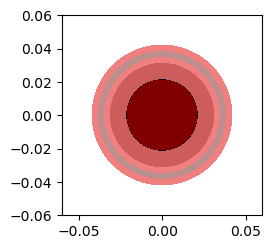

In [5]:
# Geometry definitions for Quadriso particles




kernelsph = openmc.Sphere(r=0.02125)
gadoliniasph = openmc.Sphere(r=0.02145)
buffsph = openmc.Sphere(r=0.03125)
IPyCsph = openmc.Sphere(r=0.03475)
SiCsph = openmc.Sphere(r=0.03825)
OPyCsph = openmc.Sphere(r=0.04225)



layers = [kernelsph, gadoliniasph, buffsph, IPyCsph, SiCsph, OPyCsph]
quadriso_mats = [fuel_q, gadolinia, buffer, IPyC, SiC, OPyC]
quadriso_cells = []
for i in range(6):
  if (i == 0):
    quadriso_cells.append(openmc.Cell(fill=quadriso_mats[0], region=-layers[0]))
  else:
    quadriso_cells.append(openmc.Cell(fill=quadriso_mats[i], region=+layers[i-1] & -layers[i]))

quadriso_universe = openmc.Universe(cells=quadriso_cells)
quadriso_colors = { quadriso_cells[0]: 'maroon', quadriso_cells[1]: 'black',
                quadriso_cells[2]: 'indianred', quadriso_cells[3]: ('lightcoral'), 
                quadriso_cells[4]:'rosybrown',  quadriso_cells[5]: ('lightcoral')}
quadriso_universe.plot(width = (0.12, 0.12), colors = quadriso_colors)


In [6]:
# Generating quadRISO particle lattice in cylindrical pin cell

cylsurf1 = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=(79.3/2), boundary_type='reflective')
minz = openmc.ZPlane(z0=-(79.3/2), boundary_type='reflective')

lattice_region = -cylsurf1 & -maxz & +minz
quadriso_outer_radius = 0.04225
spheres = openmc.model.pack_spheres(radius=quadriso_outer_radius, region=lattice_region, pf=0.3)



quadriso_particles = [openmc.model.TRISO(quadriso_outer_radius, fill=quadriso_universe, center=c) for c in spheres]


vol_quadriso = 4/3 * 3.14 * quadriso_outer_radius**3 * len(quadriso_particles)
actual_pf = vol_quadriso/(3.14 * (0.6225) ** 2 * 3.9)



lattice_cell1 = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell1.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
quadriso_latt = openmc.model.create_triso_lattice(quadriso_particles, lower_left, pitch, shape, graphite)

lattice_cell1.fill = quadriso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell1])


# lattice_universe.plot(width=(1.8, 1.8), color_by='cell', colors = {graphite: (97, 97, 97),
#                                                                        fuel: 'yellow'})

In [7]:
# Creating coolant cells
small_coolant_surf = openmc.ZCylinder(r=0.635)
big_coolant_surf = openmc.ZCylinder(r=0.794)

small_coolant_cell = openmc.Cell(region=-small_coolant_surf & -maxz & +minz, fill=helium)
big_coolant_cell = openmc.Cell(region=-big_coolant_surf & -maxz & +minz, fill=helium)

outside_small_cell = openmc.Cell(region=+small_coolant_surf & -maxz & +minz, fill=graphite)
outside_big_cell = openmc.Cell(region=+big_coolant_surf & -maxz & +minz, fill=graphite)

scu = openmc.Universe(cells=[small_coolant_cell, outside_small_cell]) # scu means small coolant universe
bcu = openmc.Universe(cells=[big_coolant_cell, outside_big_cell])     # bcu means big coolant universe


In [8]:
# poison_surf = openmc.ZCylinder(r=0.6375)
# poison_cell = openmc.Cell(region=-poison_surf & -maxz & +minz, fill=b4c)
# outside_poison_cell = openmc.Cell(region=+poison_surf & -maxz & +minz, fill=graphite)

# pu = openmc.Universe(cells=[poison_cell, outside_poison_cell]) # pu means poison universe
# pu.plot(width=(1.8, 1.8), color_by='material',
#                           colors = {graphite: (97, 97, 97), fuel: (238, 59, 59), helium: (240, 255, 255),
#                                     b4c: (102, 205, 0)})

In [9]:
outer_pin_region = +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region=outer_pin_region)

tpcu = openmc.Universe(cells=[lattice_cell, outer_pin_cell]) # tpcu means total pin cell universe


In [10]:
outer_pin_region1 = +cylsurf1 & -maxz & +minz
outer_pin_cell1 = openmc.Cell(fill=graphite, region=outer_pin_region1)

gpcu = openmc.Universe(cells=[lattice_cell1, outer_pin_cell1]) # gpcu means total pin cell universe

# qpcu.plot(width=(1.9, 1.9), color_by='material',
#                              colors = {graphite1: (97, 97, 97), fuel1: (238, 59, 59), helium1: (240, 255, 255),
#                                        b4c1: (102, 205, 0)})

In [11]:
outer_graphite_cell = openmc.Cell(fill=graphite)
ogu = openmc.Universe(cells=[outer_graphite_cell]) # ogu means outer graphite universe

# ogu.plot(width=(1.9, 1.9), color_by='material',
#                              colors = {graphite: (97, 97, 97), fuel: (238, 59, 59), helium: (240, 255, 255),
#                                        b4c: (102, 205, 0)})

In [12]:
# Construct geometry of the hexagonal fuel assembly
# ogu, tpcu, pu, scu, bcu
# outer_graphite_universe, total_pin_cell_universe, poison_universe, small_coolant_universe, big_coolant_universe

assemblylat = openmc.HexLattice(name="Assembly")
assemblylat.outer = ogu
assemblylat.pitch = (1.8796,)
assemblylat.center = (0.0, 0.0)
assemblylat.orientation = 'x'

outer_ring = ([ogu, tpcu, bcu] + [tpcu, tpcu, bcu]*2 + [tpcu])*2   +   ([ogu, tpcu] + [bcu, tpcu, tpcu]*2 + [bcu, tpcu])*4

ring_1 = ([bcu, tpcu, tpcu]*3)*6

ring_2 = ([tpcu] + [bcu, tpcu, tpcu]*2 + [bcu])*6

ring_3 = ([tpcu, tpcu, bcu]*2 + [tpcu])*6

ring_4 = ([bcu, gpcu, gpcu]*2)*6 #gpcu

ring_5 = [tpcu, bcu, tpcu, tpcu, bcu]*6

ring_6 = [gpcu, gpcu, bcu, gpcu]*6 #gpcu

ring_7 = [bcu, tpcu, tpcu]*6

ring_8 = [gpcu, scu]*6 #gpcu

ring_9 = [ogu]*6 

inner_ring = [ogu]

assemblylat.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     ring_6,
                     ring_7,
                     ring_8,
                     ring_9,
                     inner_ring]
print(assemblylat)


HexLattice
	ID             =	142
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.8796,)
	Outer          =	141
	Universes      
                              141   139   138   139   139   138   139   139   138   139   141
                           139   138   139   139   138   139   139   138   139   139   138   139
                        138   139   139   138   139   139   138   139   139   138   139   139   138
                     139   139   138   139   139   138   139   139   138   139   139   138   139   139
                  139   138   139   139   138   140   140   138   140   140   138   139   139   138   139
               138   139   139   138   140   139   138   139   139   138   139   140   138   139   139   138
            139   139   138   139   140   138   140   140   138   140   140   138   140   139   138   139   139
         139   138   139   139   138   139   140   138   13

In [13]:


assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])



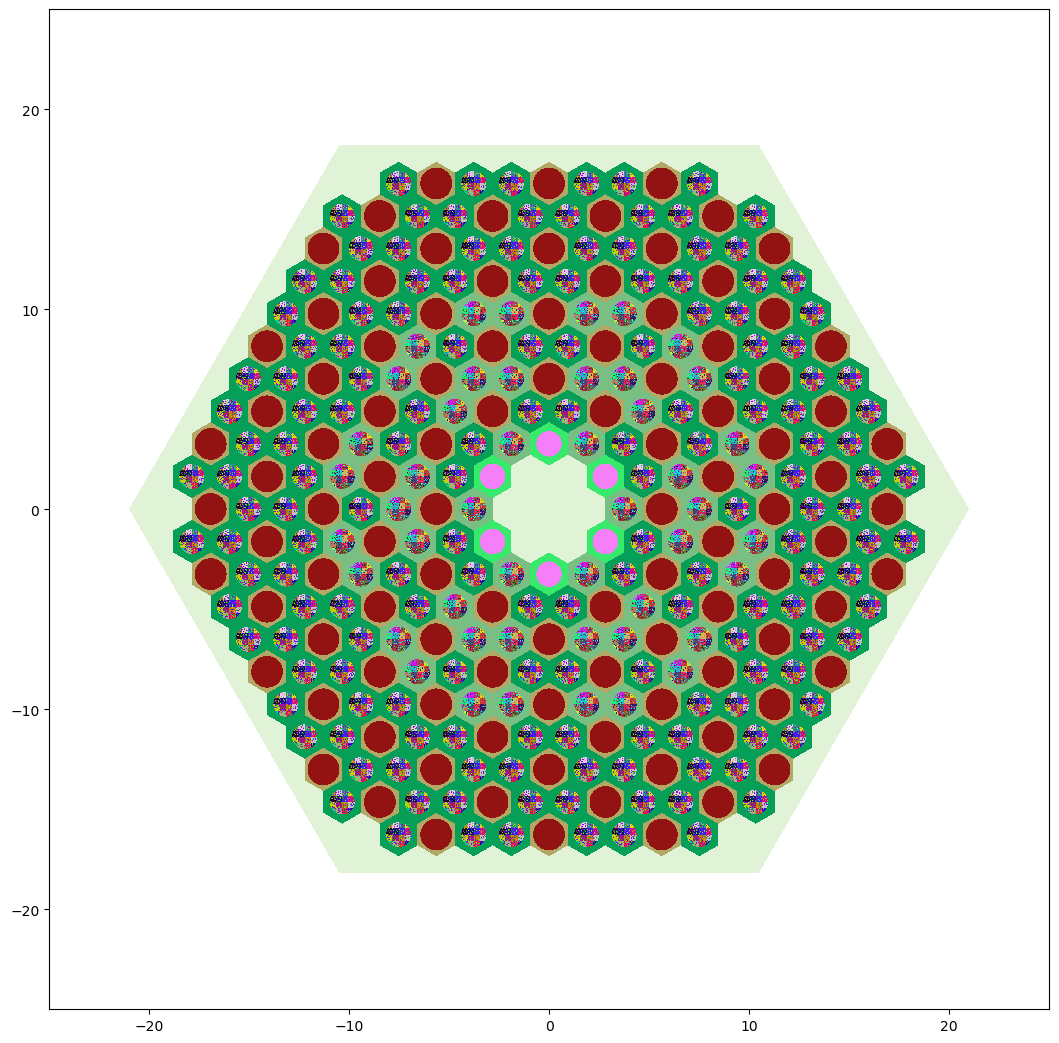

In [14]:
assembly_universe.plot(width=(50, 50), pixels = (1000, 1000), color_by='cell')
#                        colors = {graphite: (97, 97, 97), lattice_cell: (238, 59, 59), helium: (240, 255, 255),
#                                  b4c: (102, 205, 0),
#                                 graphite1: (97, 97, 97), fuel1: 'yellow', helium1: (240, 255, 255),
#                                        b4c1: (102, 205, 0)})

# assembly_universe.plot(width=(50, 50), basis = 'xz', pixels = (1000, 1000), color_by='cell')

In [15]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()



In [16]:
# OpenMC simulation parameters

batches = 20
inactive = 5
particles = 5000


In [17]:
##############################################################################
#                   Exporting to OpenMC settings.xml file
##############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML

settings_file = openmc.Settings()
settings_file.temperature = {
		 'method'    :'interpolation',
		 'tolerance' : 300.0
}
# settings_file.temperature = {'method':'interpolation'}
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)


settings_file.export_to_xml()

In [18]:
# openmc.run()

In [19]:
import math
import openmc.deplete



fuel_t.volume = 4/3 * 3.1416 * (0.02125**3) * len(triso_particles) * 162

fuel_q.volume = 4/3 * 3.1416 * (0.02125**3) * len(quadriso_particles) * 48

gadolinia.volume = 4/3 * 3.1416 * ((0.02145**3) - (0.02125**3)) * len(quadriso_particles) * 48



chain = openmc.deplete.Chain.from_xml("/home/razu/Downloads/chain_casl_pwr.xml")


model = openmc.Model(geometry=geom, settings=settings_file)
operator = openmc.deplete.CoupledOperator(model, "/home/razu/Downloads/chain_casl_pwr.xml")

power = 113.1 * operator.heavy_metal



In [20]:
print(power)

815902.7845350493


In [21]:



time_steps = [30] * 20

integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')



In [22]:


# integrator.integrate()



In [23]:
!ls *.h5

depletion_results.h5	  openmc_simulation_n16.h5  openmc_simulation_n4.h5
openmc_simulation_n0.h5   openmc_simulation_n17.h5  openmc_simulation_n5.h5
openmc_simulation_n10.h5  openmc_simulation_n18.h5  openmc_simulation_n6.h5
openmc_simulation_n11.h5  openmc_simulation_n19.h5  openmc_simulation_n7.h5
openmc_simulation_n12.h5  openmc_simulation_n1.h5   openmc_simulation_n8.h5
openmc_simulation_n13.h5  openmc_simulation_n20.h5  openmc_simulation_n9.h5
openmc_simulation_n14.h5  openmc_simulation_n2.h5   statepoint.20.h5
openmc_simulation_n15.h5  openmc_simulation_n3.h5   summary.h5


In [24]:
results = openmc.deplete.Results("./depletion_results.h5")



time, k = results.get_keff()



time /= (24 * 60 * 60)  # convert back to days from seconds




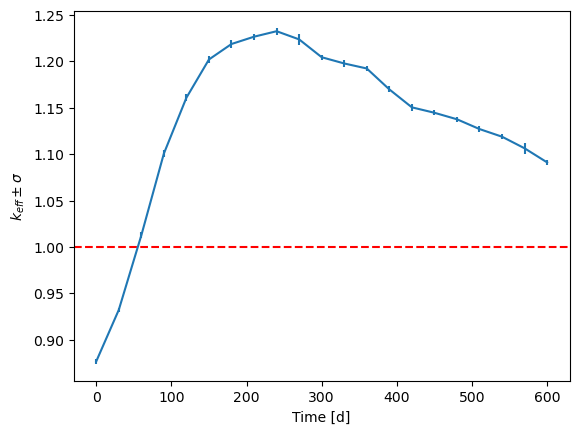

In [25]:

from matplotlib import pyplot



pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

pyplot.axhline(y = 1, color = 'r', linestyle = '--')



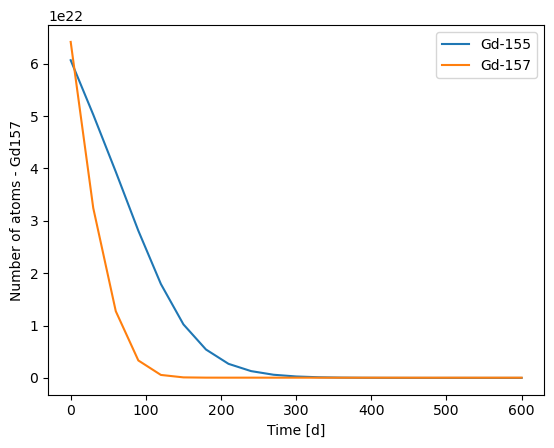

In [26]:

_, Gd155 = results.get_atoms("9", "Gd155")
pyplot.plot(time, Gd155, label="Gd-155")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Gd155");



_, Gd157 = results.get_atoms("9", "Gd157")
pyplot.plot(time, Gd157, label="Gd-157")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Gd157");
pyplot.legend()


In [27]:


_, u235 = results.get_atoms("1", "U235")
_, u235_q = results.get_atoms("2", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_, Sm149 = results.get_atoms("1", "Sm149")
_, pu239 = results.get_atoms("1", "Pu239")
_, pu239_q = results.get_atoms("2", "Pu239")


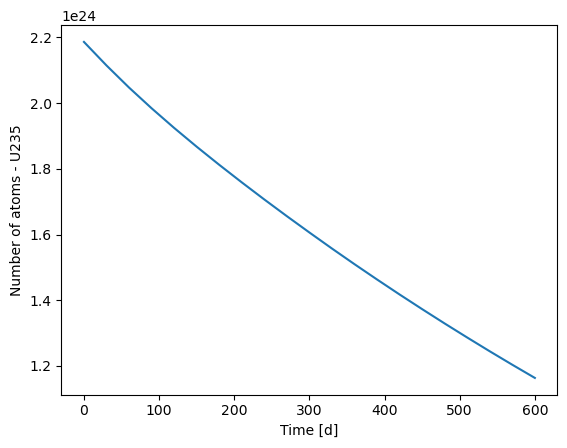

In [28]:

pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");



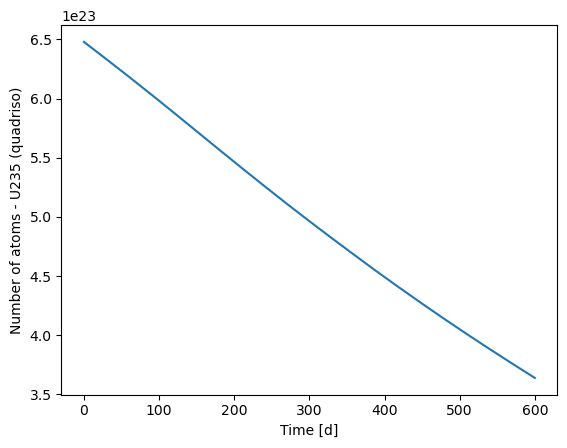

In [29]:
pyplot.plot(time, u235_q, label="U235 (quadriso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235 (quadriso)");

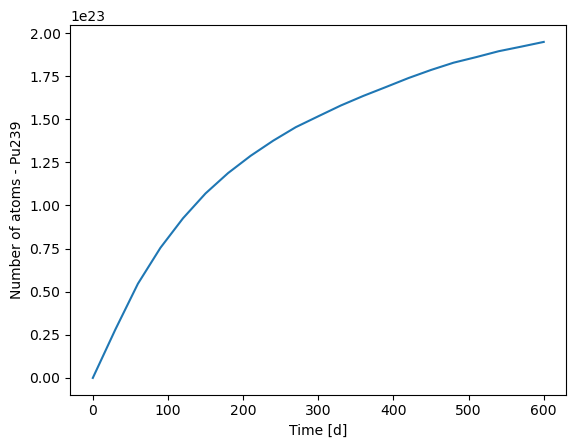

In [30]:
pyplot.plot(time, pu239, label="Pu239")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

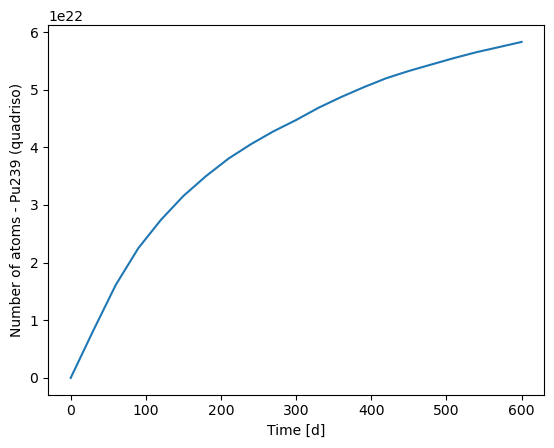

In [31]:
pyplot.plot(time, pu239_q, label="Pu239 (quadriso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239 (quadriso)");

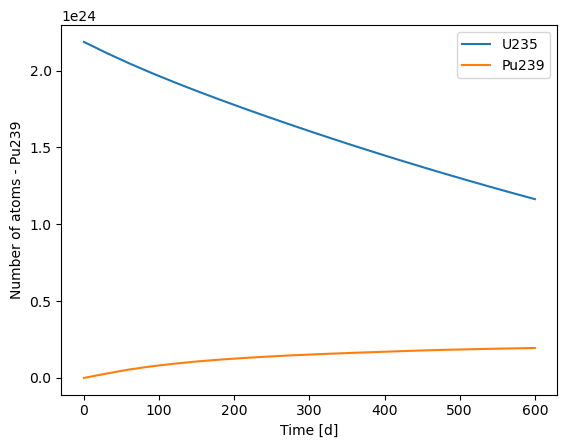

In [32]:

pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");

pyplot.plot(time, pu239, label="Pu239")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.legend()

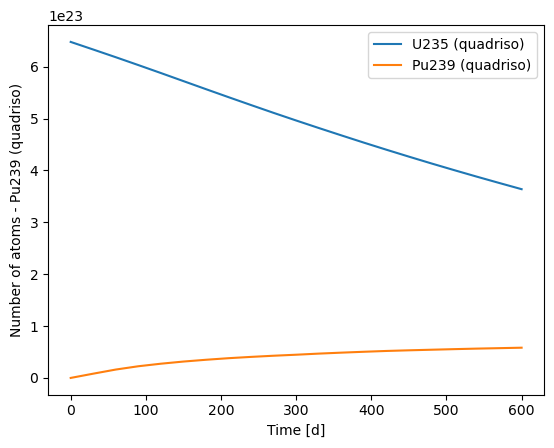

In [33]:
pyplot.plot(time, u235_q, label="U235 (quadriso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235 (quadriso)");

pyplot.plot(time, pu239_q, label="Pu239 (quadriso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239 (quadriso)");

pyplot.legend()

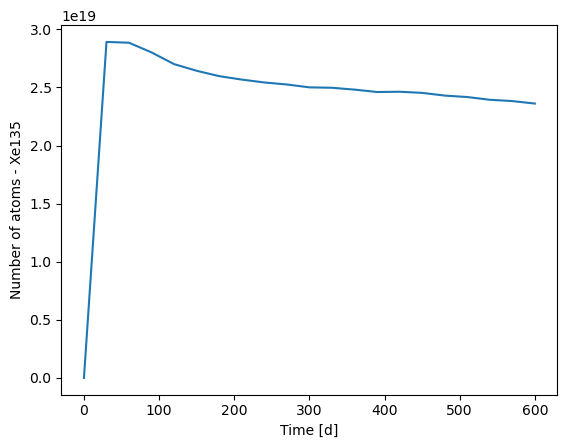

In [34]:



pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");



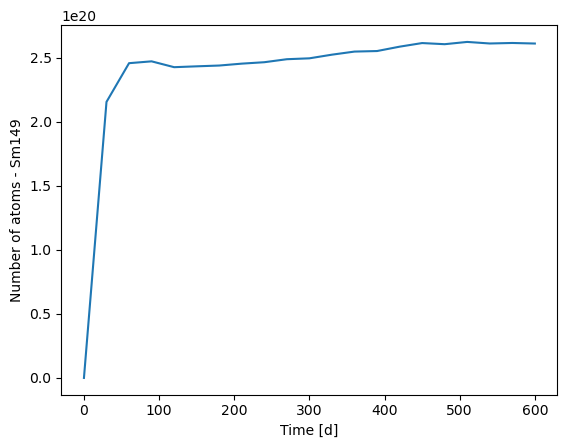

In [35]:





















































pyplot.plot(time, Sm149, label="Sm149")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Sm149");

In [36]:
_, u235_fission = results.get_reaction_rate("1", "U235", "fission")

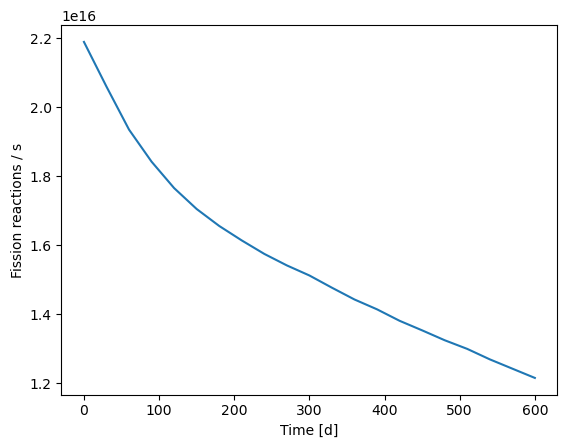

In [37]:

pyplot.plot(time, u235_fission)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

In [38]:
_, u235_fission_q = results.get_reaction_rate("2", "U235", "fission")

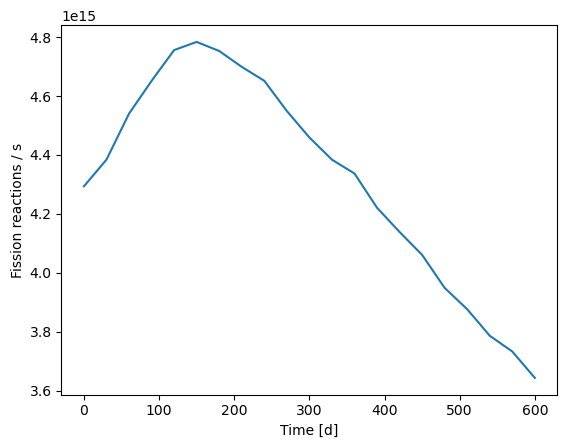

In [39]:
pyplot.plot(time, u235_fission_q)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

In [40]:
t = results.get_depletion_time()
t

array([0.2443467 , 0.24378514, 0.24285269, 0.24019655, 0.2442615 ,
       0.24563448, 0.24471299, 0.24418561, 0.24511925, 0.24541823,
       0.24257207, 0.24549794, 0.24694967, 0.24524736, 0.24585684,
       0.24452949, 0.25177066, 0.24966065, 0.24636626, 0.24814963])

In [41]:
k

array([[0.87655326, 0.00268527],
       [0.93209161, 0.00193008],
       [1.01241108, 0.00325863],
       [1.10057329, 0.00341277],
       [1.16080077, 0.0037158 ],
       [1.20201426, 0.00362632],
       [1.21869919, 0.00405046],
       [1.22656488, 0.00318925],
       [1.23247871, 0.00355302],
       [1.22367648, 0.00577437],
       [1.20445636, 0.00267019],
       [1.1977222 , 0.00371245],
       [1.19230877, 0.00315471],
       [1.16980181, 0.00327119],
       [1.15043051, 0.00389242],
       [1.14458474, 0.00255214],
       [1.1375738 , 0.00254281],
       [1.12702072, 0.00285225],
       [1.1187697 , 0.0028708 ],
       [1.10628068, 0.0056719 ],
       [1.09107494, 0.00270051]])

In [42]:
k_gadolinia_quad = []
for i in range(0,len(k),1):
    k_gadolinia_quad.append(k[i][0])
print(k_gadolinia_quad)
len(k_gadolinia_quad)

[0.8765532629500091, 0.9320916055125033, 1.0124110816344394, 1.1005732874915404, 1.1608007745409203, 1.20201426253101, 1.2186991855921327, 1.2265648773667168, 1.2324787082193343, 1.2236764834248384, 1.2044563614892771, 1.1977221961426283, 1.1923087717723282, 1.1698018069155791, 1.1504305051095713, 1.1445847388240704, 1.137573803080932, 1.127020724770935, 1.1187696960257774, 1.106280680331727, 1.0910749433596774]


21

In [43]:
t1 = results.get_times(time_units = 'd') 
t1

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330., 360., 390., 420., 450., 480., 510., 540., 570., 600.])

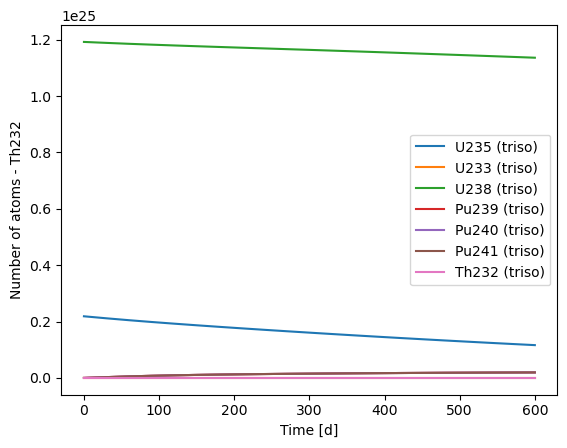

In [44]:

#fissile
_, u235 = results.get_atoms("1", "U235")
_, u233 = results.get_atoms("1", "U233")


_, pu239 = results.get_atoms("1", "Pu239")
_, pu241 = results.get_atoms("1", "Pu239")

#poisons
_, xe135 = results.get_atoms("1", "Xe135")
_, sm149 = results.get_atoms("1", "Sm149")



#fertile
_, th232 = results.get_atoms("1", "Th232")
_, u238 = results.get_atoms("1", "U238")
_, pu240 = results.get_atoms("1", "Pu239")


#fissile
_, u235_q = results.get_atoms("2", "U235")
_, u233_q = results.get_atoms("2", "U233")


_, pu239_q = results.get_atoms("2", "Pu239")
_, pu241_q = results.get_atoms("1", "Pu239")

#poisons
_, xe135_q = results.get_atoms("2", "Xe135")
_, sm149_q = results.get_atoms("2", "Sm149")



#fertile
_, th232_q = results.get_atoms("2", "Th232")
_, u238_q = results.get_atoms("2", "U238")
_, pu240_q = results.get_atoms("2", "Pu239")


pyplot.plot(time, u235, label="U235 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");


pyplot.plot(time, u233, label="U233 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U233");

pyplot.plot(time, u238, label="U238 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U238");

pyplot.plot(time, pu239, label="Pu239 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.plot(time, pu240, label="Pu240 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu240");

pyplot.plot(time, pu241, label="Pu241 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu241");

pyplot.plot(time, th232, label="Th232 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Th232");
pyplot.legend()



u235_all = u235 + u235_q
u233_all = u233 + u233_q
pu239_all = pu239 + pu239_q
pu241_all = pu241 + pu241_q

u238_all = u238 + u238_q
pu240_all = pu240 + pu240_q

xe135_all = xe135 + xe135_q
sm149_all = sm149 + sm149_q






In [45]:

print(u233_all)

print(u235_all)

print(u238_all)

print(pu239_all)

print(pu240_all)

print(pu241_all)

print(xe135_all)

print(sm149_all)

[7.73814104e+05 1.08469818e+15 1.69381400e+15 2.73375801e+15
 3.06614020e+15 3.91956659e+15 4.79560279e+15 4.89878759e+15
 5.24986066e+15 5.99081805e+15 6.76795435e+15 6.99672653e+15
 7.87149570e+15 8.35162646e+15 8.77030779e+15 9.09690494e+15
 9.93966261e+15 1.02595067e+16 1.08205587e+16 1.19801048e+16
 1.26598193e+16]
[2.83426137e+24 2.74794073e+24 2.66579592e+24 2.58760612e+24
 2.51245895e+24 2.43971535e+24 2.36903975e+24 2.30013663e+24
 2.23281593e+24 2.16693053e+24 2.10252409e+24 2.03926803e+24
 1.97742108e+24 1.91681033e+24 1.85748438e+24 1.79949708e+24
 1.74266459e+24 1.68714879e+24 1.63267269e+24 1.57946275e+24
 1.52729724e+24]
[1.54512959e+25 1.54072003e+25 1.53650603e+25 1.53265135e+25
 1.52902444e+25 1.52550207e+25 1.52212889e+25 1.51879299e+25
 1.51548412e+25 1.51215763e+25 1.50889253e+25 1.50548037e+25
 1.50205983e+25 1.49858965e+25 1.49500662e+25 1.49140804e+25
 1.48778582e+25 1.48416901e+25 1.48045720e+25 1.47675129e+25
 1.47295560e+25]
[7.73814104e+05 3.62938378e+22 7.0

[2.61850940e+16 2.49805034e+16 2.38916028e+16 2.30743842e+16
 2.24141276e+16 2.18359593e+16 2.13143572e+16 2.08414458e+16
 2.04040386e+16 1.99683594e+16 1.95870887e+16 1.91572975e+16
 1.87692080e+16 1.83680170e+16 1.79538826e+16 1.75993498e+16
 1.72010279e+16 1.68780226e+16 1.64854576e+16 1.61624963e+16
 1.58042140e+16]


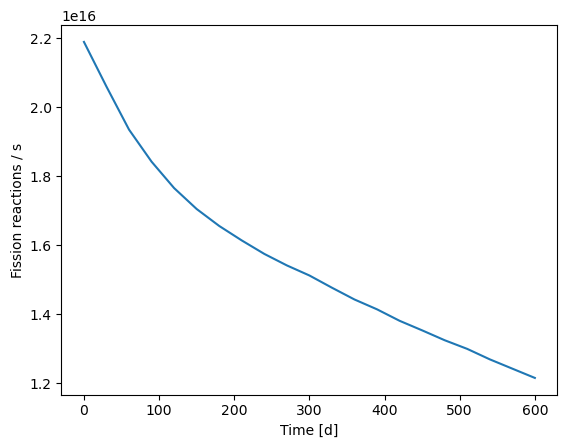

In [46]:


_, u235_fission = results.get_reaction_rate("1", "U235", "fission")
_, u235_fission_q = results.get_reaction_rate("2", "U235", "fission")

pyplot.plot(time, u235_fission)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

overall_fission_reaction_rate= u235_fission+u235_fission_q
print(overall_fission_reaction_rate)